In [30]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

def categorical_information(train_df, x, y):
    df_temp = train_df.groupby(x).mean().reset_index()
    fig, axes = plt.subplots(1,2, figsize = (15,5))
    
    sns.barplot(df_temp, x = x, y = y, ax = axes[0])
    axes[0].set_title("Total " + y + " by " + x)
    
    sns.boxplot(train_df, x = x, y = y, ax = axes[1])
    axes[1].set_title("Distribution of " + y + " by " + x)
    
    plt.show()

## **Files**

- **train.csv** - historical data including Sales
- **test.csv** - historical data excluding Sales
- **sample_submission.csv** - a sample submission file in the correct format
- **store.csv** - supplemental information about the stores

## **Data fields**

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- **Id** - an Id that represents a (Store, Date) duple within the test set
- **Store** - a unique Id for each store
- **Sales** - the turnover for any given day (this is what you are predicting)
- **Customers** - the number of customers on a given day
- **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
- **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo** - indicates whether a store is running a promo on that day
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [2]:
train_df = pd.read_csv("data/train.csv")
store_df = pd.read_csv("data/store.csv")
test_df = pd.read_csv("data/test.csv")

C:\Users\gocal\AppData\Local\Temp\ipykernel_9524\806370972.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("data/train.csv")


In [16]:
train_df.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [33]:
train_df["StateHoliday"] = train_df["StateHoliday"].astype(str)

In [34]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0


In [23]:
store_df.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [24]:
store_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,1115.0,558.000000,322.017080,1.0,279.5,558.0,836.5,1115.0
CompetitionDistance,1112.0,5404.901079,7663.174720,20.0,717.5,2325.0,6882.5,75860.0
CompetitionOpenSinceMonth,761.0,7.224704,3.212348,1.0,4.0,8.0,10.0,12.0
CompetitionOpenSinceYear,761.0,2008.668857,6.195983,1900.0,2006.0,2010.0,2013.0,2015.0
Promo2,1115.0,0.512108,0.500078,0.0,0.0,1.0,1.0,1.0
Promo2SinceWeek,571.0,23.595447,14.141984,1.0,13.0,22.0,37.0,50.0
Promo2SinceYear,571.0,2011.763573,1.674935,2009.0,2011.0,2012.0,2013.0,2015.0


In [115]:
df = train_df.join(store_df.set_index("Store"), on= "Store", lsuffix="store")

df["CompetitionOpenSinceYear"] = df["CompetitionOpenSinceYear"].fillna(2050)
df["CompetitionOpenSinceMonth"] = df["CompetitionOpenSinceMonth"].fillna(1)
df["Sales/Customers"] = df["Sales"] / df["Customers"]
df["Date"] = pd.to_datetime(df["Date"])
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["CompetitionDurationDays"]= (df["Date"] - pd.to_datetime(df["CompetitionOpenSinceYear"].astype(int).astype(str) + "/" + df["CompetitionOpenSinceMonth"].astype(int).astype(str) + "/1")).dt.days
df["CompetitionDurationDays"] = df["CompetitionDurationDays"].map(lambda x: None if x < 0 else x)

In [122]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales/Customers,Year,Month,CompetitionDurationDays
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,9.482883,2015,7,2524.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",9.702400,2015,7,2829.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",10.126675,2015,7,3164.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,9.342457,2015,7,2159.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,8.626118,2015,7,121.0


In [123]:
df.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
Sales/Customers                     float64
Year                                  int64
Month                                 int64
CompetitionDurationDays             float64
dtype: object

In [56]:
tempdf = df.query("Store == 2").sort_values("Date")

fig = go.Figure()
fig.add_trace(go.Scatter(x = tempdf["Date"], y = tempdf["Sales"]))
fig.add_trace(go.Scatter(x = tempdf[tempdf["Promo"] == 1]["Date"], y = tempdf[tempdf["Promo"] == 1]["Sales"], mode = "markers"))
fig

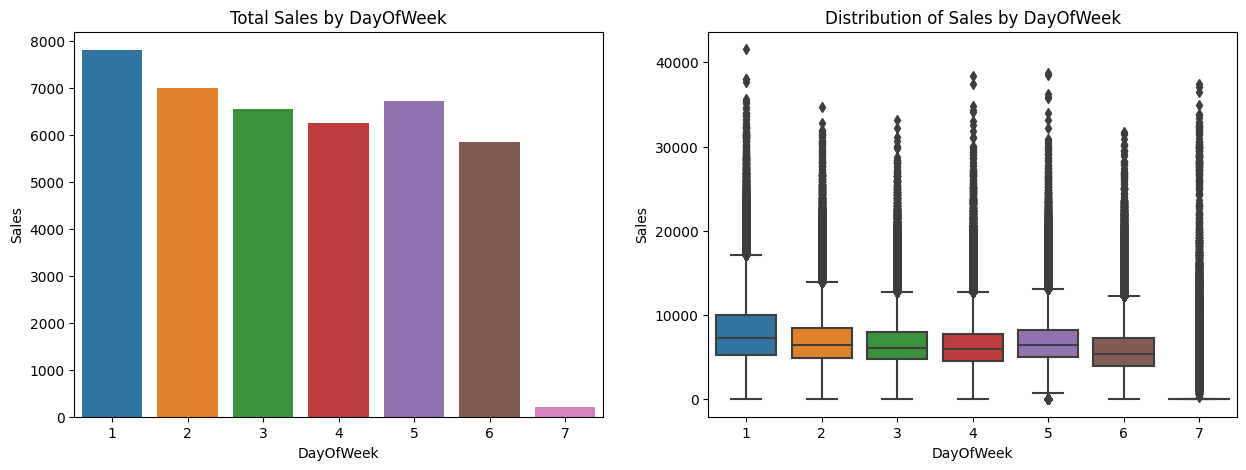

In [31]:
categorical_information(df, "DayOfWeek", "Sales")

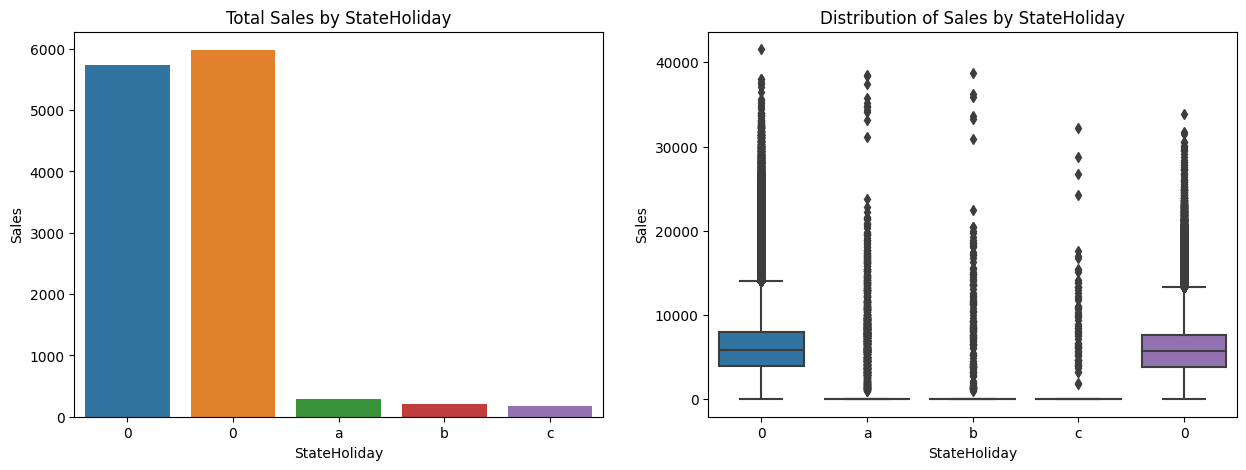

In [32]:
categorical_information(df, "StateHoliday", "Sales")

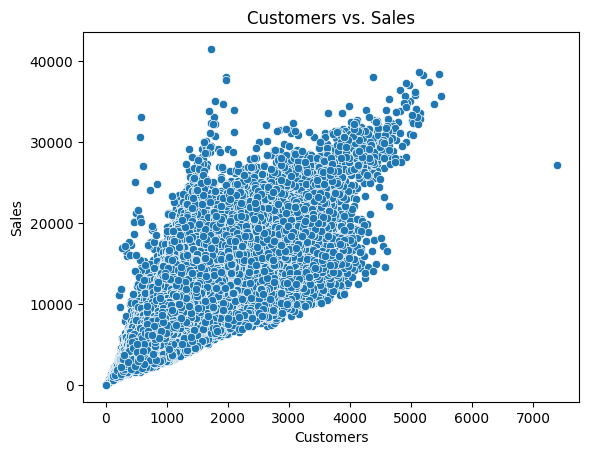

In [42]:
sns.scatterplot(df, x = "Customers", y = "Sales")
plt.title("Customers vs. Sales")
plt.show()

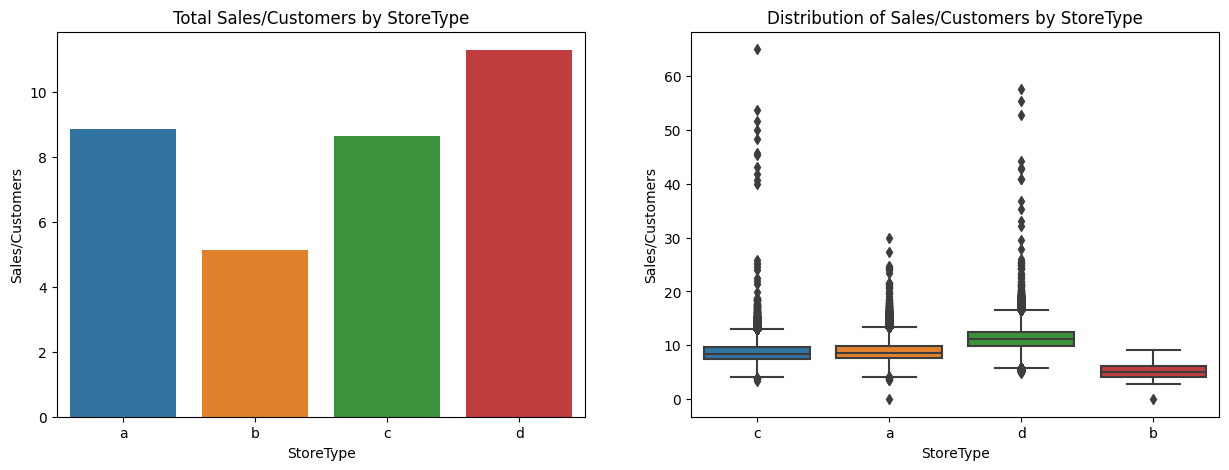

In [43]:
categorical_information(df, "StoreType", "Sales/Customers")

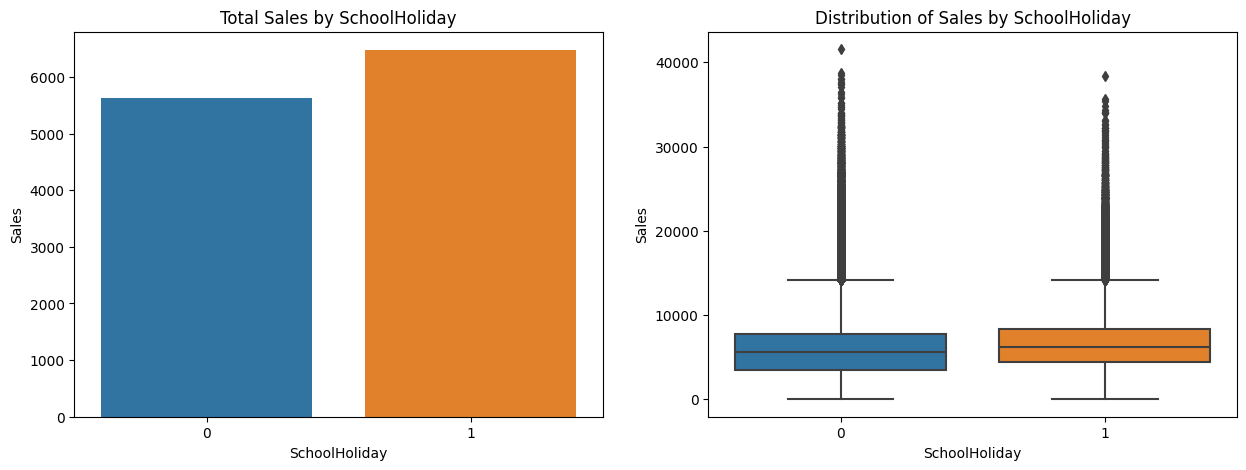

In [34]:
categorical_information(df, "SchoolHoliday", "Sales")

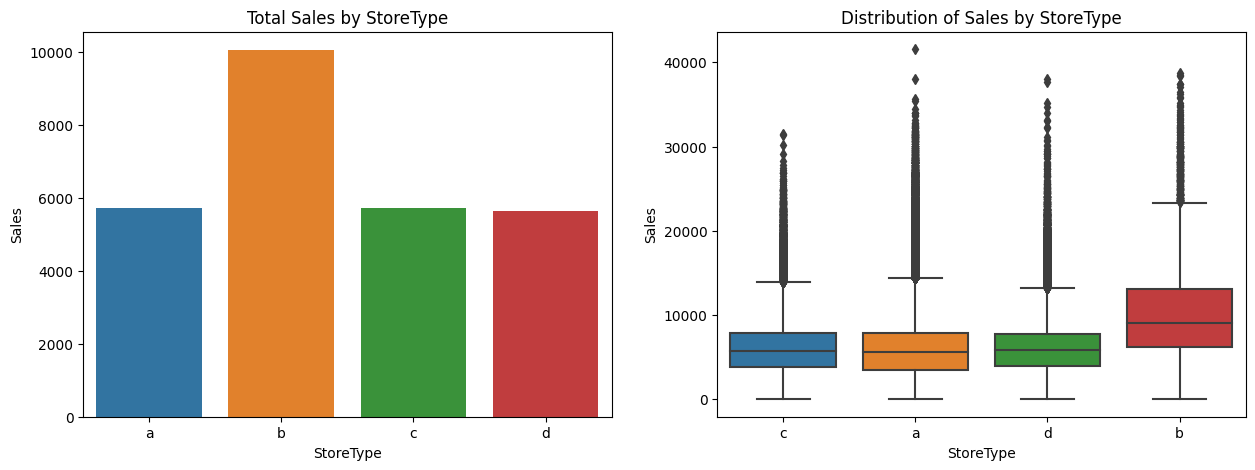

In [35]:
categorical_information(df, "StoreType", "Sales")

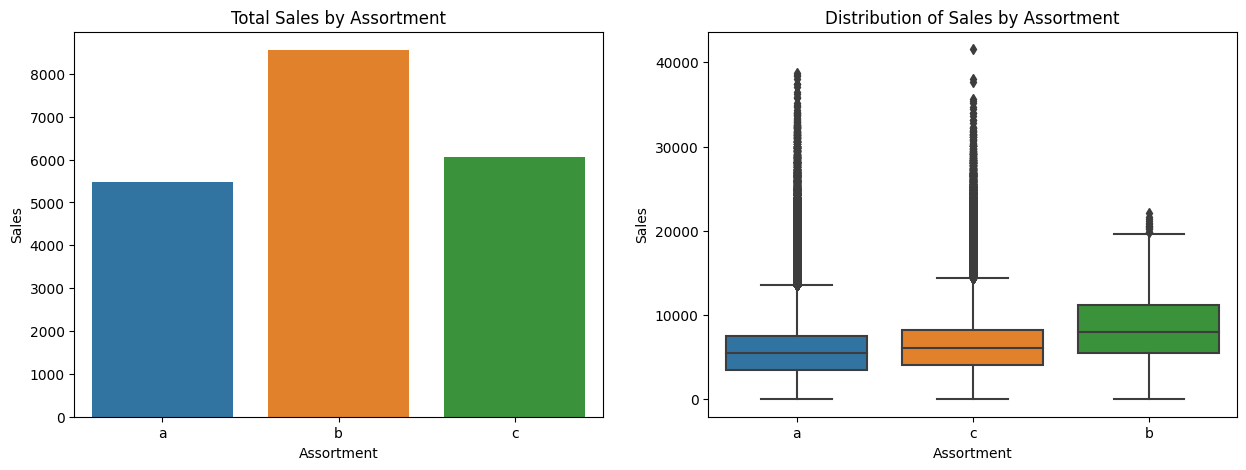

In [37]:
categorical_information(df, "Assortment", "Sales")

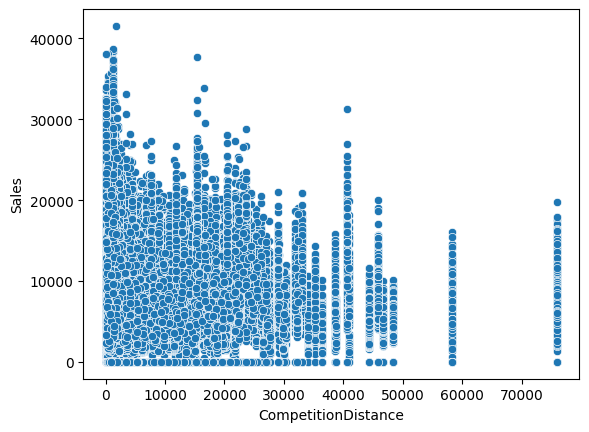

In [38]:
sns.scatterplot(df, x = "CompetitionDistance", y = "Sales")
plt.show()

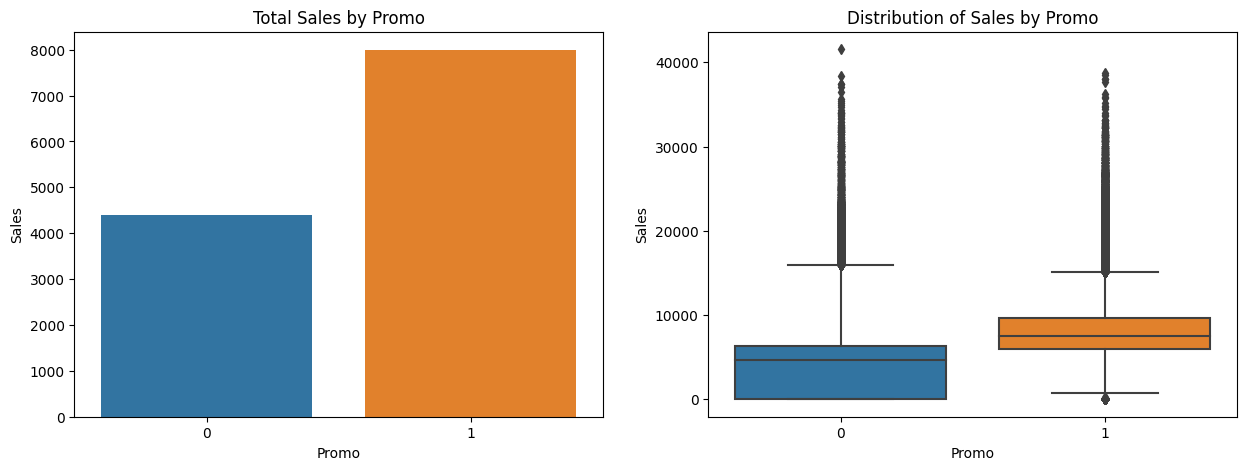

In [39]:
categorical_information(df, "Promo", "Sales")

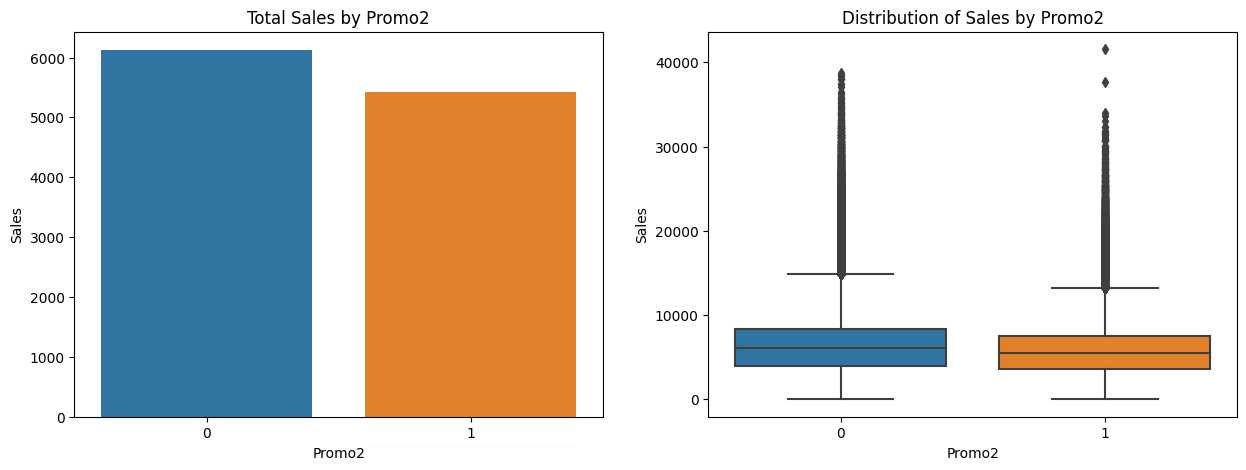

In [40]:
categorical_information(df, "Promo2", "Sales")

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df["Sales"])